In [1]:
import os
import sys
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set(style="white", context="paper")
plt.rc("axes.spines", top=False, right=False, left=False, bottom=False)
import scienceplots
plt.style.context(['science', 'ieee', 'high-vis'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from visualization import visualize
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from data.sampler import Sampler


COUNTRY = 'best models'
TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

TRAIN_PATH1, TEST_PATH1 = get_data_filepaths('full_merged')
TRAIN_PATH2, TEST_PATH2 = get_data_filepaths('full_merged_dumvar')
    
ERRORS_DIR = Path('..', 'data', 'processed', 'best models', 'errors')
ERRORS_DIR.mkdir(exist_ok=True)

In [2]:
#Logistic Regression
# Load and transform the test set
X_test_log, y_test_log, w_test_log = load_data(TEST_PATH2)

#XGBoost
# Load the test set
X_test_xgb, y_test_xgb, w_test_xgb = split_features_labels_weights(TEST_PATH1)
X_test_xgb = X_test_xgb.to_numpy()
w_test_xgb = w_test_xgb.to_numpy().reshape(-1)


#Random Forest
# Load the test set
X_test_rf, y_test_rf, w_test_rf = split_features_labels_weights(TEST_PATH1)
X_test_rf['age'].fillna(2.0, inplace=True)
y_test_rf = np.ravel(y_test_rf)
w_test_rf = np.ravel(w_test_rf)

In [3]:
files = os.listdir(os.path.join(evaluation.MODELS_DIR, COUNTRY))
models = [f[:-4] for f in files if f[-4:] == '.pkl']

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,mean_rank
xgb_final,0.806732,0.871099,0.818369,0.843911,0.412976,0.878330,0.497999,1.285714
lr_final,0.796322,0.877615,0.801606,0.837890,0.427212,0.871574,0.502633,2.000000
rf_final,0.791659,0.844887,0.814632,0.829484,0.429839,0.875281,0.481680,2.714286


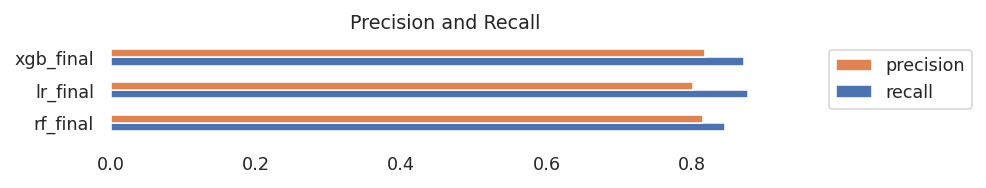

In [4]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in models]
results = visualize.display_model_comparison(metrics, 
                                             show_roc=False, 
                                             show_cm=False, 
                                             show_dig_rate_error=False, 
                                             highlight_best=True, 
                                             transpose=True, 
                                             rank_order=True)
visualize.display_precision_recall(results)

In [5]:
TOP_N = 3
top_models = results.iloc[:TOP_N].index.values
top_models

array(['xgb_final', 'lr_final', 'rf_final'], dtype=object)

In [6]:
models = [evaluation.load_model(f, COUNTRY) for f in top_models]

In [7]:
model_names = [model['name'] for model in models]

In [8]:
print(f"number of predictions:\t{y_test_xgb.shape[0]}")
print(f"number of models:\t{len(model_names)}")

number of predictions:	1452
number of models:	3


In [9]:
# to hold all predicted labels
all_preds = np.zeros((len(model_names), models[0]['y_pred'].shape[0]))

# to hold all predicted class probabilities
all_probs = np.zeros_like(all_preds)

all_preds.shape

(3, 1452)

In [10]:
for i, model in enumerate(models):
    all_preds[i, :] = model['y_pred'].ravel()
    all_probs[i, :] = model['y_prob'].ravel()
    
all_preds_df = pd.DataFrame(all_preds.T, index=y_test_xgb.index, columns=top_models).astype(bool)
all_preds_df['y_test'] = y_test_xgb.astype(bool)

y = all_preds_df[['xgb_final']]

In [11]:
%matplotlib inline

import os
from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 450)

from pandas.io.stata import StataReader
from tqdm import tqdm

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set(style="white", context="paper")
plt.rc("axes.spines", top=False, right=False, left=False, bottom=False)
import scienceplots
plt.style.context(['science', 'ieee', 'high-vis'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sys.path.append(os.path.join(os.pardir, 'src'))
from data import load_data

from sklearn.model_selection import train_test_split

ERRORS_DIR = Path('..', 'data', 'processed', 'best models', 'errors')

In [12]:
def load_csv_file(filepath):
    
    """ 
    Load data in correct format from CSV file
    
    Parameters:
    -----------
    filepath : a filepath to the file to be loaded
        
    Returns:
    --------
    data: the processed dataframe 
    
    """
    data = pd.read_csv(filepath)
    
    #drop the regionwb column
    data.drop(['regionwb', 'receive_welfare_payments'], axis=1, inplace = True)
    
    #define function to categorize age
    def categorize_age(data):
        data.loc[(data['age'] >= 15) & (data['age'] <= 24), 'age'] = 1
        data.loc[(data['age'] >= 25) & (data['age'] <= 44), 'age'] = 2
        data.loc[(data['age'] >= 45) & (data['age'] <= 64), 'age'] = 3
        data.loc[data['age'] >= 65, 'age'] = 4
        data['age'] = data['age'].astype('category')
        return data
    # call the function and assign the returned value back to data
    data = categorize_age(data)
    
    # convert those who responded to receiving wages through other methods to digital wage receipients
    # and rename the variable from receive_wages to receive_digital_wages
    data.loc[data.receive_wages == 3, 'receive_wages'] = 1
    data.rename( columns={'receive_wages':'receive_digital_wages'}, inplace=True )
    
    # rename the first column to be id (referencing row position in original uncleaned data) and setting it as index
    data.rename( columns={'Unnamed: 0':'id'}, inplace=True )
    data.set_index('id', inplace = True)
    
    numeric_variables = ['pop_scaled_wgt']
    # convert the categorical variables into the category type
    for c in data.columns:
        if c not in numeric_variables:
            data[c] = data[c].astype('category')
    
    #Drop Algeria, Gabon, Mauritius and Morocco due to missing values not at random
    data.dropna(subset = ['urbanicity_f2f'], inplace=True)
    
    data['economy'] = data['economy'].cat.remove_unused_categories()
      
    return data

In [13]:
filepath = load_data.FULL_MERGED
full_merged_data = load_csv_file(filepath)

full_merged_data.receive_digital_wages = (full_merged_data.receive_digital_wages == 1)
full_merged_data.head()


,economy,pop_scaled_wgt,female,age,educ,inc_q,emp_in,urbanicity_f2f,account,fin14_1,...,fin22b,fin24,fin33,receive_digital_wages,pay_utilities,remittances,mobileowner,internetaccess,merchantpay_dig,internet_fin_transc
id,,,,,,,,,,,,,,,,,,,,,
9023,Benin,4731.949144,2,1.0,2,5,1.0,1.0,1,2,...,2,2,2.0,False,4,1.0,1,1,0.0,1
9026,Benin,4469.830001,1,1.0,2,3,1.0,2.0,1,2,...,2,1,2.0,True,2,1.0,1,2,0.0,2
9027,Benin,17001.509861,1,3.0,2,5,1.0,2.0,1,2,...,1,2,1.0,True,1,1.0,1,1,0.0,1
9028,Benin,9407.418933,2,1.0,2,2,1.0,1.0,1,2,...,2,3,2.0,False,4,1.0,1,1,0.0,1
9034,Benin,4830.758167,2,3.0,2,5,1.0,1.0,1,2,...,1,2,1.0,True,4,1.0,1,2,0.0,1


In [14]:
# join with expenditure data
exp_and_fp = y.join(full_merged_data)
exp_and_fp['misprediction']= False
exp_and_fp.loc[((exp_and_fp['xgb_final'] == True) & (exp_and_fp['receive_digital_wages'] == False)) |
               ((exp_and_fp['xgb_final'] == False) & (exp_and_fp['receive_digital_wages'] == True)), 'misprediction'] = True
exp_and_fp.drop(['xgb_final', 'pop_scaled_wgt', 'economy', 'receive_digital_wages'], axis=1, inplace = True)

In [15]:
exp_and_fp.misprediction.sum()

320

In [16]:
exp_and_fp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 118568 to 104173
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   female               1452 non-null   category
 1   age                  1452 non-null   category
 2   educ                 1452 non-null   category
 3   inc_q                1452 non-null   category
 4   emp_in               1452 non-null   category
 5   urbanicity_f2f       1452 non-null   category
 6   account              1452 non-null   category
 7   fin14_1              1452 non-null   category
 8   fin16                1452 non-null   category
 9   fin17a               1452 non-null   category
 10  fin17b               1452 non-null   category
 11  fin22a               1452 non-null   category
 12  fin22b               1452 non-null   category
 13  fin24                1452 non-null   category
 14  fin33                1452 non-null   category
 15  pay_utilities 

In [27]:
from rule_induction import diagnoser
import collections

In [33]:
# for c in exp_and_fp.columns:
#     exp_and_fp[c] = exp_and_fp[c].astype('float')
    
target = diagnoser.Target(attribute = 'misprediction', value = False)
# relevant_attributes ={
#  'female': 1,
#  'age': 1,
#  'educ': 1,
#  'inc_q': 1,
#  'emp_in': 1,
#  'urbanicity_f2f': 1,
#  'account': 1,
#  'fin14_1': 1,
#  'fin16': 1,
#  'fin17a': 1,
#  'fin17b': 1,
#  'fin22a': 1,
#  'fin22b': 1,
#  'fin24': 1,
#  'fin33': 1,
#  'pay_utilities': 1,
#  'remittances': 1,
#  'mobileowner': 1,
#  'internetaccess': 1,
#  'merchantpay_dig': 1,
#  'internet_fin_transc': 1,
#  'misprediction': 1
# }
relevant_attributes ={
 'female': 'C',
 'age': 'C',
 'educ': 'C',
 'inc_q': 'C',
 'emp_in': 'C',
 'urbanicity_f2f': 'C',
 'account': 'C',
 'fin14_1': 'C',
 'fin16': 'C',
 'fin17a': 'C',
 'fin17b': 'C',
 'fin22a': 'C',
 'fin22b': 'C',
 'fin24': 'C',
 'fin33': 'C',
 'pay_utilities': 'C',
 'remittances': 'C',
 'mobileowner': 'C',
 'internetaccess': 'C',
 'merchantpay_dig': 'C',
 'internet_fin_transc': 'C',
 'misprediction': 'C'
}

In [41]:
result = diagnoser.discover(exp_and_fp, target, relevant_attributes)

In [42]:
result

misprediction<=False